In [1]:
import os

from collections import deque
import importlib
import torch as T
import gymnasium as gym

import policygradient
importlib.reload(policygradient)

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from IPython.display import clear_output

In [2]:
env_id = "CartPole-v1"
env = gym.make(env_id)#,render_mode="human")

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  4
Sample observation [ 2.2699654e+00 -2.1814009e+38 -1.4900842e-01 -5.4033247e+37]


In [3]:
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")

In [4]:
layer1 = 32
layer2 = 64
gamma = 0.99
learning_rate = 0.0001
episodes = 100_000
avg_win_size = 50
epi_results = deque(maxlen=avg_win_size)

agent = policygradient.ReInforceBaseline(s_size, a_size, layer1, layer2, gamma = gamma)

In [5]:
log_file_name = os.path.join('.','artefacts',f'{env_id}_policygradient_baseline.csv')
model_file = os.path.join('.','models',f'{env_id}_policygradient_baseline.pth')

In [9]:
train = False
if train:
    log_file = open(log_file_name, "w")
    log_file.write(f'episode,loss,rewards,adv\n')

for epi in range(episodes):

    if not train:
        print("set train flag to True for Training")
        break

    s = env.reset()[0]
    done = False
    rewards, states , actions = [], [], []
    
    while not done:

        states.append(s)
        obs = T.FloatTensor(np.expand_dims(s,0)).to(device)

        with T.no_grad():
            p_vals = agent.policy_net(obs)
            p_vals = T.squeeze(p_vals)

        p_vals = p_vals.detach().cpu().numpy()
        a = np.random.choice(a_size, p=p_vals)

        s_, r, done ,_ , _  = env.step(a)
        actions.append(a)
        rewards.append(r)
          
        s=np.copy(s_)

    epi_results.append(np.sum(rewards))
    loss, adv = agent.train(states, rewards, actions, loss_scaler = 0.001)
    
    log_file.write(f'{epi},{loss:.2f},{np.sum(rewards):.2f}, {adv.item():.4f}\n')

    if epi%100==0:
        clear_output()
    if epi%10==0:
        print(f'epi:{epi:05d} reward:{np.sum(rewards):8.2f} loss:{loss:8.2f} mean_rewards:{np.mean(epi_results):8.2f}')
    if np.mean(epi_results)>=500:
        break

if train:
    print(f'Saving Agent as {model_file}')
    agent.save(model_file)
    log_file.close()

epi:00500 reward:  298.00 loss:   10.99 mean_rewards:  281.18
epi:00510 reward:  272.00 loss:    9.72 mean_rewards:  379.92
Saving Agent as .\models\CartPole-v1_policygradient_baseline.pth


In [10]:
eval_agent =  policygradient.ReInforceBaseline(s_size, a_size, layer1, layer2, gamma = gamma)
eval_agent.load(model_file)
df = pd.read_csv(log_file_name)
df['mean_rewards'] = df['rewards'].rolling(avg_win_size).mean()

Text(0.5, 1.0, 'Advantage')

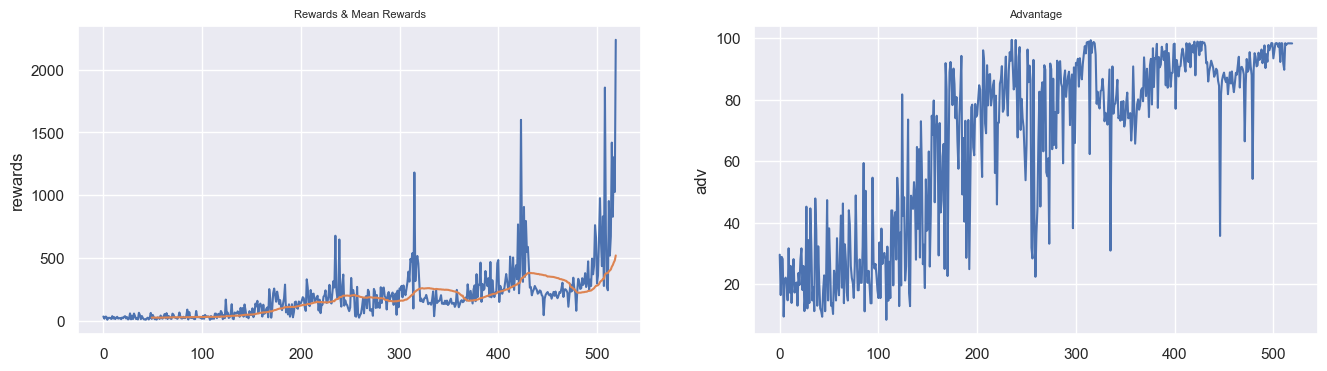

In [11]:
fig,ax=plt.subplots(1,2,sharex='col',sharey= False,figsize=(16,4))

sns.lineplot(df['rewards'], ax = ax[0])
sns.lineplot(df['mean_rewards'],ax = ax[0])
ax[0].set_title('Rewards & Mean Rewards',fontsize=8)

sns.lineplot(df['adv'],ax = ax[1])
ax[1].set_title('Advantage',fontsize=8)

In [12]:
eval_env = gym.make(env_id,render_mode="human")

for epi in range(10):

    s = eval_env.reset()[0]
    term = False
    trunc = False
    score = 0

    while not any([term, trunc]):

        obs = T.FloatTensor(np.expand_dims(s,0)).to(device)

        with T.no_grad():
            p_vals = eval_agent.policy_net(obs)
            p_vals = T.squeeze(p_vals)

        p_vals = p_vals.detach().cpu().numpy()
        
        a = np.argmax(p_vals)
        s, r, term ,trunc , _  = eval_env.step(a)
        
        score+=r
        
    print(f'{epi = } result {score:4.2f}')
eval_env.close()

epi = 0 result 500.00
epi = 1 result 500.00
epi = 2 result 500.00
epi = 3 result 500.00
epi = 4 result 500.00
epi = 5 result 500.00
epi = 6 result 500.00
epi = 7 result 500.00
epi = 8 result 500.00
epi = 9 result 500.00
